## The goal is to try to find a subspace with positive EV and then try to lower the variance with independednt (or negatively correlated) samples

In [1]:
# imports
import pickle
import pulp
from pulp import *
import re
import pandas as pd
import numpy as np
import itertools
import pickle

In [2]:
# read in the data
DATE = '2019-03-02'

file = open("2018_season_second_half.pkl",'rb')
data = pickle.load(file)


example_contest = data[DATE]['CONTESTS'][0]['PAYOUTS']
example_results = data[DATE]['ACTUAL_POINTS']
example_projections = data[DATE]['PROJECTIONS']

COST = data[DATE]['CONTESTS'][0]['Buy In']
example_results

#example_projections

,Player,Pos,Avg,Fpts,"NBA $125K Four Point Play [20 Entry Max, 2x Min Cash]",NBA $35K Excellent 8's,NBA $400K Saturday Special [$100K to 1st],NBA $35K Showtime [Single Entry],NBA $4M Fantasy Basketball World Championship Final [$500K to 1st],NBA Single Entry $25 Double Up
0,Rajon Rondo,PG/G/UTIL,69.75%,18.00,49.77% (-19.98),66.52% (-3.23),55.13% (-14.62),72.16% (2.41),86.00% (16.25),88.91% (19.16)
1,Russell Westbrook,PG/G/UTIL,57.19%,41.25,41.73% (-15.46),51.72% (-5.47),42.97% (-14.22),63.14% (5.95),61.00% (3.81),82.60% (25.41)
2,Bam Adebayo,PF/C/F/UTIL,51.27%,42.00,36.02% (-15.25),41.56% (-9.71),36.42% (-14.85),57.47% (6.20),60.00% (8.73),76.14% (24.87)
3,Justise Winslow,PG/SF/F/G/UTIL,46.42%,28.00,35.44% (-10.98),43.27% (-3.15),36.34% (-10.08),52.84% (6.42),45.00% (-1.42),65.63% (19.21)
4,Dennis Schroder,PG/SG/G/UTIL,44.58%,29.75,29.78% (-14.80),44.36% (-0.22),30.14% (-14.44),45.88% (1.30),52.00% (7.42),65.34% (20.76)
...,...,...,...,...,...,...,...,...,...,...
259,Dejounte Murray,PG/G/UTIL,0.00%,NaN,0.00% (0.00),0.00% (0.00),0.00% (0.00),0.00% (0.00),0.00% (0.00),0.00% (0.00)
260,Quincy Pondexter,SF/F/UTIL,0.00%,NaN,0.00% (0.00),0.00% (0.00),0.00% (0.00),0.00% (0.00),0.00% (0.00),0.00% (0.00)
261,Ben Moore,PF/F/UTIL,0.00%,NaN,0.00% (0.00),0.00% (0.00),0.00% (0.00),0.00% (0.00),0.00% (0.00),0.00% (0.00)
262,Andre Roberson,SG/SF/F/G/UTIL,0.00%,NaN,0.00% (0.00),0.00% (0.00),0.00% (0.00),0.00% (0.00),0.00% (0.00),0.00% (0.00)


In [3]:
# process the data
#trasform the columns so the names agree with each other
def process_name(name):
    filtered = re.sub(r'([^\s\w]|_)+', '', name)
    #dumb edge cases
    if filtered == 'Moe Harkless':
        filtered = 'Maurice Harkless'
    if filtered == 'Wes Iwundu':
        filtered = 'Wesley Iwundu'
    if filtered == 'Juan Hernangomez':
        filtered = 'Juancho Hernangomez'
    return filtered.split()[0]+ " " + filtered.split()[1]
example_projections = dict((process_name(key), value) for (key, value) in example_projections.items())
example_results.Player = example_results.Player.apply(lambda x: process_name(x))

In [4]:
data["2018-12-31"]['ACTUAL_POINTS']

,Player,Pos,Avg,Fpts,NBA $100K Mini Year End Special,NBA $450K Big Jam [$100K to 1st],NBA $150K Medium Year End Special,NBA $450K Year End Special [$100K to 1st!],NBA $95K Courtside Special [$30K to 1st],NBA Single Entry $25 Double Up
0,Tyus Jones,PG/G/UTIL,63.53%,41.00,45.69% (-17.84),50.75% (-12.79),61.05% (-2.48),63.62% (0.09),75.76% (12.23),84.34% (20.81)
1,James Harden,PG/SG/G/UTIL,50.84%,82.00,40.14% (-10.70),39.49% (-11.35),46.77% (-4.07),46.75% (-4.09),60.61% (9.77),71.26% (20.42)
2,Jakob Poeltl,C/UTIL,36.33%,16.50,19.23% (-17.10),23.38% (-12.95),40.90% (4.57),38.79% (2.46),45.45% (9.12),50.23% (13.90)
3,Karl-Anthony Towns,C/UTIL,32.58%,69.75,21.74% (-10.84),24.26% (-8.32),31.00% (-1.58),33.16% (0.58),43.94% (11.36),41.37% (8.79)
4,Andrew Wiggins,SG/SF/F/G/UTIL,32.06%,31.00,22.47% (-9.59),24.27% (-7.79),32.55% (0.49),34.55% (2.49),39.39% (7.33),39.14% (7.08)
...,...,...,...,...,...,...,...,...,...,...
160,Trevon Bluiett,SG/SF/F/G/UTIL,0.00%,NaN,0.00% (0.00),0.00% (0.00),0.00% (0.00),0.00% (0.00),0.00% (0.00),0.00% (0.00)
161,Jawun Evans,PG/G/UTIL,0.00%,NaN,0.00% (0.00),0.00% (0.00),0.00% (0.00),0.00% (0.00),0.00% (0.00),0.00% (0.00)
162,Ben Moore,PF/F/UTIL,0.00%,NaN,0.00% (0.00),0.00% (0.00),0.00% (0.00),0.00% (0.00),0.00% (0.00),0.00% (0.00)
163,Dejounte Murray,PG/G/UTIL,0.00%,NaN,0.00% (0.00),0.00% (0.00),0.00% (0.00),0.00% (0.00),0.00% (0.00),0.00% (0.00)


In [5]:
# need to normalize all of the names
for date in data:
    print(date)
    if data[date]['PROJECTIONS'] is not False:
        data[date]['PROJECTIONS'] = dict((process_name(key), value) for (key, value) in data[date]['PROJECTIONS'].items())
        data[date]['ACTUAL_POINTS'] = data[date]['ACTUAL_POINTS'].Player.apply(lambda x: process_name(x))

2018-12-31
2019-01-01
2019-01-02
2019-01-03
2019-01-04
2019-01-05
2019-01-06
2019-01-07
2019-01-08
2019-01-09
2019-01-10
2019-01-11
2019-01-12
2019-01-13
2019-01-14
2019-01-15
2019-01-16
2019-01-17
2019-01-18
2019-01-19
2019-01-20
2019-01-21
2019-01-22
2019-01-23
2019-01-24
2019-01-25
2019-01-26
2019-01-27
2019-01-28
2019-01-29
2019-01-30
2019-01-31
2019-02-01
2019-02-02
2019-02-03
2019-02-04
2019-02-05
2019-02-06
2019-02-07
2019-02-08
2019-02-09
2019-02-10
2019-02-11
2019-02-12
2019-02-13
2019-02-14
2019-02-15
2019-02-17
2019-02-21
2019-02-22
2019-02-23
2019-02-24
2019-02-25
2019-02-26
2019-02-27
2019-02-28
2019-03-01
2019-03-02
2019-03-03
2019-03-04
2019-03-05
2019-03-06
2019-03-07
2019-03-08
2019-03-09
2019-03-10
2019-03-11
2019-03-12
2019-03-13
2019-03-14
2019-03-15
2019-03-16
2019-03-17
2019-03-18
2019-03-19
2019-03-20
2019-03-21
2019-03-22
2019-03-23
2019-03-24
2019-03-25
2019-03-26
2019-03-27
2019-03-28
2019-03-29
2019-03-30
2019-03-31
2019-04-01
2019-04-02
2019-04-03
2019-04-04

In [24]:
# some important helper functions

def add_position_requirement(prob,example_results, example_projections, choices, pos, number):
    players = list(example_projections.keys())
    POS = list(example_results[example_results.apply(lambda x: pos in x['Pos'].split('/'), axis=1)].Player)
    POS = [re.sub(r'([^\s\w]|_)+', '', a) for a in POS]
    POS = [name.split()[0]+ " " + name.split()[1] for name in POS]
    prob += lpSum([choices[v] for v in POS if v in players]) >= number

def add_all_position_requirements(prob, results, projections, choices):
    add_position_requirement(prob, results, projections,choices, 'C',1)
    add_position_requirement(prob, results, projections,choices,  'PG', 1)
    add_position_requirement(prob, results, projections,choices, 'SG', 1)
    add_position_requirement(prob, results, projections,choices, 'PF', 1)
    add_position_requirement(prob, results, projections,choices, 'SF', 1)
    add_position_requirement(prob, results, projections,choices, 'F', 2)
    add_position_requirement(prob, results, projections,choices, 'G', 2)
    
def get_Fpts(df, player):
    df = df[df['Player'] == player]
    #print(df)
    #print(player)
    try:
        return 0 if np.isnan(df.iloc[0].Fpts) else df.iloc[0].Fpts
    except:
        #print("??? {}".format(player))
        return 0
def get_payout(df, points):
    df = df[df['Points'] < points]
    if df.empty:
        return 0
    try:
        return float(df.iloc[0].Prize[1:].replace(",",""))
    except:
        return 0

In [45]:
# uses linear algebra to return a random lineup that satisfies certain constraints
def get_max_ev(results, projections):
    players = list(example_projections.keys())
    
    # Instantiate our problem class
    prob = pulp.LpProblem("NBA Maximizing EV", pulp.LpMaximize)
    choices = LpVariable.dicts("Choice", players, cat='Binary')
    
    # 8 people to a team
    prob += lpSum([choices[v] for v in players]) == 8
    
    #add all the necessary position constraints
    add_all_position_requirements(prob, results, projections, choices)
    #adding in the salary constraint
    prob += pulp.lpDot([choices[v] for v in players],[example_projections[name]['salary'] for name in players]) <= 50001

    #optimizing function
    prob += pulp.lpDot([choices[v] for v in players],[example_projections[name]['points'] for name in players]), "Total Projection"
    prob.solve()
    return(value(prob.objective))
# uses linear algebra to return a random lineup that satisfies certain constraints
def get_max_var(results, projections):
    players = list(example_projections.keys())
    
    # Instantiate our problem class
    prob = pulp.LpProblem("NBA Maximizing Var", pulp.LpMaximize)
    choices = LpVariable.dicts("Choice", players, cat='Binary')
    
    # 8 people to a team
    prob += lpSum([choices[v] for v in players]) == 8
    
    #add all the necessary position constraints
    add_all_position_requirements(prob, results, projections, choices)
    #adding in the salary constraint
    prob += pulp.lpDot([choices[v] for v in players],[example_projections[name]['salary'] for name in players]) <= 50001

    #optimizing function
    prob += pulp.lpDot([choices[v] for v in players],
                       [(example_projections[name]['ceil']/2-example_projections[name]['floor']/2)**2 for name in players]), "Total Variance"
    
    prob.solve()
    return(value(prob.objective))

def get_random_lineup(results, projections, optimal_variance_ratio=.9, optimal_expected_ratio=.9):
    players = list(example_projections.keys())
    max_var = get_max_var(results, projections)
    max_ev = get_max_ev(results, projections)
    #print(max_var)
    
    # Instantiate our problem class
    prob = pulp.LpProblem("NBA Maximizing Var", pulp.LpMaximize)
    choices = LpVariable.dicts("Choice", players, cat='Binary')
    
    # 8 people to a team
    prob += lpSum([choices[v] for v in players]) == 8
    
    #add all the necessary position constraints
    add_all_position_requirements(prob, results, projections, choices)
    #adding in the salary constraint
    prob += pulp.lpDot([choices[v] for v in players],[example_projections[name]['salary'] for name in players]) <= 50001
    
    #additional EV and Var constraints
    prob += pulp.lpDot([choices[v] for v in players],
                       [(example_projections[name]['ceil']/2-example_projections[name]['floor']/2)**2 for name in players]) \
        >= max_var*optimal_variance_ratio
    prob += pulp.lpDot([choices[v] for v in players],[example_projections[name]['points'] for name in players]) \
    >= max_ev*optimal_expected_ratio
    
    #optimizing function
    prob += pulp.lpDot([choices[v] for v in players],[np.random.randint(100) for name in players]), "Total Projection"
    prob.solve()
    #for v in prob.variables():
    #    print(v.name, "=", v.varValue)
    print(pulp.lpDot([choices[v].varValue for v in players],
                    [example_projections[name]['points'] for name in players]))
    return(value(prob.objective))
def get_random_lineup_actual(results, projections, optimal_variance_ratio=.9, optimal_expected_ratio=.9):
    players = list(set(example_projections.keys()).intersection(list(results.Player)))
    max_var = get_max_var(results, projections)
    max_ev = get_max_ev(results, projections)
    #print(max_var)
    
    # Instantiate our problem class
    prob = pulp.LpProblem("NBA Maximizing Var", pulp.LpMaximize)
    choices = LpVariable.dicts("Choice", players, cat='Binary')
    
    # 8 people to a team
    prob += lpSum([choices[v] for v in players]) == 8
    
    #add all the necessary position constraints
    add_all_position_requirements(prob, results, projections, choices)
    #adding in the salary constraint
    prob += pulp.lpDot([choices[v] for v in players],[example_projections[name]['salary'] for name in players]) <= 50001
    
    #additional EV and Var constraints
    prob += pulp.lpDot([choices[v] for v in players],
                       [(example_projections[name]['ceil']/2-example_projections[name]['floor']/2)**2 for name in players]) \
        >= max_var*optimal_variance_ratio
    prob += pulp.lpDot([choices[v] for v in players],[example_projections[name]['points'] for name in players]) \
    >= max_ev*optimal_expected_ratio
    
    #optimizing function
    prob += pulp.lpDot([choices[v] for v in players],[np.random.randint(2) for name in players]), "Total Projection"
    prob.solve()
    #for v in prob.variables():
    #    print(v.name, "=", v.varValue)
    print((pulp.lpDot([choices[v].varValue for v in players],
                    [get_Fpts(results, name) for name in players])))
    print(pulp.lpDot([choices[v].varValue for v in players],[example_projections[name]['points'] for name in players]))
    print([choices[v] for v in players if choices[v].varValue == 1])
    #return(value(prob.objective))
    #return prob
    return(pulp.lpDot([choices[v].varValue for v in players],
                    [get_Fpts(results, name) for name in players])).value()

def get_random_payout(results, projections, optimal_variance_ratio=.9, optimal_expected_ratio=.9):
    global example_contest
    points = get_random_lineup_actual(results, projections,
                                      optimal_variance_ratio=optimal_variance_ratio, optimal_expected_ratio=optimal_expected_ratio)
    payout = get_payout(example_contest, points) - float(COST[1:])
    return payout

In [46]:
get_random_lineup_actual(example_results, example_projections, optimal_variance_ratio=.90, optimal_expected_ratio=.90)

293.5
278.51
[Choice_Dennis_Schroder, Choice_Myles_Turner, Choice_Jerami_Grant, Choice_DeMarre_Carroll, Choice_Donovan_Mitchell, Choice_Derrick_White, Choice_Stephen_Curry, Choice_Julius_Randle]


293.5

In [21]:

get_Fpts(example_results, 'Marquese Chriss')

??? Marquese Chriss


0

In [22]:
df = example_results[example_results['Player'] == 'Marquese Chriss']
a = 0 if np.isnan(df.iloc[0].Fpts) else df.iloc[0].Fpts

IndexError: single positional indexer is out-of-bounds

In [23]:
df

,Player,Pos,Avg,Fpts,"NBA $125K Four Point Play [20 Entry Max, 2x Min Cash]",NBA $35K Excellent 8's,NBA $400K Saturday Special [$100K to 1st],NBA $35K Showtime [Single Entry],NBA $4M Fantasy Basketball World Championship Final [$500K to 1st],NBA Single Entry $25 Double Up


In [39]:
get_random_payout(example_results, example_projections, optimal_variance_ratio=.95, optimal_expected_ratio=.95)

224.75
285.53000000000003
[Choice_Dennis_Smith, Choice_Bruno_Caboclo, Choice_Frank_Kaminsky, Choice_Buddy_Hield, Choice_Khris_Middleton, Choice_Trae_Young, Choice_Myles_Turner, Choice_Joel_Embiid]


-8.0

In [40]:
payments = []
for i in range(100):
    val = get_random_payout(example_results, example_projections, optimal_variance_ratio=.95, optimal_expected_ratio=.95)
    payments.append(val)

237.5
280.98
[Choice_Bruno_Caboclo, Choice_Frank_Kaminsky, Choice_Alec_Burks, Choice_Domantas_Sabonis, Choice_Buddy_Hield, Choice_Khris_Middleton, Choice_DeAndre_Bembry, Choice_Trae_Young]
251.5
280.86
[Choice_Bruno_Caboclo, Choice_Frank_Kaminsky, Choice_Domantas_Sabonis, Choice_Buddy_Hield, Choice_Khris_Middleton, Choice_DeAndre_Bembry, Choice_Richaun_Holmes, Choice_Trae_Young]
264.0
281.96000000000004
[Choice_Bruno_Caboclo, Choice_Frank_Kaminsky, Choice_Eric_Paschall, Choice_Domantas_Sabonis, Choice_Buddy_Hield, Choice_Khris_Middleton, Choice_Trae_Young, Choice_Myles_Turner]
264.0
281.96000000000004
[Choice_Bruno_Caboclo, Choice_Frank_Kaminsky, Choice_Eric_Paschall, Choice_Domantas_Sabonis, Choice_Buddy_Hield, Choice_Khris_Middleton, Choice_Trae_Young, Choice_Myles_Turner]
238.0
285.77
[Choice_Dennis_Smith, Choice_Bruno_Caboclo, Choice_Alec_Burks, Choice_Domantas_Sabonis, Choice_Buddy_Hield, Choice_Jaren_Jackson, Choice_Trae_Young, Choice_Myles_Turner]
230.75
282.73
[Choice_Dennis_Sm

225.25
282.51000000000005
[Choice_Dennis_Smith, Choice_Bruno_Caboclo, Choice_Alec_Burks, Choice_Domantas_Sabonis, Choice_Buddy_Hield, Choice_Khris_Middleton, Choice_Trae_Young, Choice_Myles_Turner]
224.75
283.35
[Choice_Dennis_Smith, Choice_Bruno_Caboclo, Choice_Alec_Burks, Choice_Domantas_Sabonis, Choice_Buddy_Hield, Choice_Trae_Young, Choice_Myles_Turner, Choice_Jeremy_Lamb]
248.75
284.69000000000005
[Choice_Bruno_Caboclo, Choice_Frank_Kaminsky, Choice_Grayson_Allen, Choice_Solomon_Hill, Choice_Domantas_Sabonis, Choice_Buddy_Hield, Choice_Trae_Young, Choice_Joel_Embiid]
227.75
283.79
[Choice_Dennis_Smith, Choice_Bruno_Caboclo, Choice_Frank_Kaminsky, Choice_Domantas_Sabonis, Choice_Buddy_Hield, Choice_Khris_Middleton, Choice_Trae_Young, Choice_Terry_Rozier]
248.75
284.69000000000005
[Choice_Bruno_Caboclo, Choice_Frank_Kaminsky, Choice_Grayson_Allen, Choice_Solomon_Hill, Choice_Domantas_Sabonis, Choice_Buddy_Hield, Choice_Trae_Young, Choice_Joel_Embiid]
244.5
282.8
[Choice_Dennis_Smith

242.5
285.8
[Choice_Dennis_Smith, Choice_Bruno_Caboclo, Choice_Eric_Paschall, Choice_Domantas_Sabonis, Choice_Buddy_Hield, Choice_Khris_Middleton, Choice_Trae_Young, Choice_Terry_Rozier]
232.0
283.26
[Choice_Dennis_Smith, Choice_Bruno_Caboclo, Choice_Dillon_Brooks, Choice_Domantas_Sabonis, Choice_Buddy_Hield, Choice_Khris_Middleton, Choice_Trae_Young, Choice_Terry_Rozier]
261.75
282.31
[Choice_Bruno_Caboclo, Choice_Frank_Kaminsky, Choice_Ky_Bowman, Choice_Eric_Paschall, Choice_Domantas_Sabonis, Choice_Buddy_Hield, Choice_Trae_Young, Choice_Myles_Turner]
244.0
283.45
[Choice_Bruno_Caboclo, Choice_Frank_Kaminsky, Choice_Alec_Burks, Choice_Dillon_Brooks, Choice_Domantas_Sabonis, Choice_Buddy_Hield, Choice_Trae_Young, Choice_Myles_Turner]
227.75
283.79
[Choice_Dennis_Smith, Choice_Bruno_Caboclo, Choice_Frank_Kaminsky, Choice_Domantas_Sabonis, Choice_Buddy_Hield, Choice_Khris_Middleton, Choice_Trae_Young, Choice_Terry_Rozier]
230.75
282.73
[Choice_Dennis_Smith, Choice_Bruno_Caboclo, Choice_

In [304]:
get_random_lineup_actual(example_results, example_projections, optimal_variance_ratio=.99, optimal_expected_ratio=.99)

2293.0743374999997
295.3963021399999
[Choice_Tyus_Jones, Choice_Noah_Vonleh, Choice_Lonzo_Ball, Choice_DAngelo_Russell, Choice_KarlAnthony_Towns, Choice_Nikola_Jokic]


NBA Maximizing Var:
MAXIMIZE
32*Choice_Alfonzo_McKinnie + 1*Choice_Allen_Crabbe + 72*Choice_Allonzo_Trier + 86*Choice_Andre_Drummond + 7*Choice_Andre_Iguodala + 56*Choice_Andrew_Wiggins + 68*Choice_Anthony_Davis + 19*Choice_Anthony_Tolliver + 16*Choice_Antonio_Blakeney + 33*Choice_Blake_Griffin + 49*Choice_Bojan_Bogdanovic + 96*Choice_Brandon_Ingram + 32*Choice_Bruce_Brown + 94*Choice_Bryn_Forbes + 78*Choice_Cameron_Payne + 31*Choice_Caris_LeVert + 2*Choice_Chandler_Hutchison + 97*Choice_Cory_Joseph + 76*Choice_Cristiano_Felicio + 87*Choice_DAngelo_Russell + 18*Choice_Damian_Jones + 66*Choice_Damyean_Dotson + 78*Choice_Dante_Cunningham + 10*Choice_Dante_Exum + 15*Choice_Darren_Collison + 93*Choice_Davis_Bertans + 93*Choice_DeAndre_Jordan + 47*Choice_DeMar_DeRozan + 21*Choice_Deandre_Ayton + 43*Choice_Dennis_Smith + 82*Choice_Derrick_Favors + 25*Choice_Derrick_Rose + 78*Choice_Domantas_Sabonis + 3*Choice_Donovan_Mitchell + 12*Choice_Dorian_FinneySmith + 23*Choice_Doug_McDermott + 20*Cho

In [345]:
sum(payments)/len(payments)

-10.0

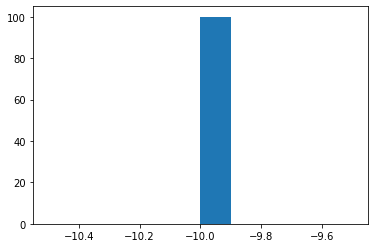

In [346]:
import matplotlib.pyplot as plt

plt.hist(payments)
plt.show()

In [ ]:
sum(payments)/len(payments)

In [49]:
example_projections

{'AlFarouq Aminu': {'ceil': 42.18,
  'floor': 19.08,
  'points': 26.8,
  'salary': 4000.0},
 'Brook Lopez': {'ceil': 42.29,
  'floor': 15.8,
  'points': 24.69,
  'salary': 4100.0},
 'Dario Saric': {'ceil': 45.84,
  'floor': 16.63,
  'points': 29.33,
  'salary': 4900.0},
 'Julius Randle': {'ceil': 74.86,
  'floor': 32.45,
  'points': 37.73,
  'salary': 6400.0},
 'DeAaron Fox': {'ceil': 63.98,
  'floor': 20.62,
  'points': 39.35,
  'salary': 6700.0},
 'Buddy Hield': {'ceil': 65.2,
  'floor': 24.01,
  'points': 37.58,
  'salary': 6400.0},
 'Monte Morris': {'ceil': 27.4,
  'floor': 4.62,
  'points': 22.85,
  'salary': 3900.0},
 'Cody Zeller': {'ceil': 39.49,
  'floor': 14.65,
  'points': 23.15,
  'salary': 4000.0},
 'Jrue Holiday': {'ceil': 67.41,
  'floor': 22.62,
  'points': 41.74,
  'salary': 7300.0},
 'Tim Frazier': {'ceil': 37.73,
  'floor': 15.54,
  'points': 19.38,
  'salary': 3400.0},
 'Malcolm Brogdon': {'ceil': 45.63,
  'floor': 18.63,
  'points': 25.59,
  'salary': 4500.0},
 'Im

NameError: name 'prob' is not defined

In [58]:
np.random.randint(100)

67

In [118]:
data1[DATE]['standings'][0]['Buy In']

{'Name': 'NBA $425K Excellent 8’s [$100K to 1st!]',
 'Link': 'Contest',
 'Prize Pool': '$425,000',
 'Buy In': '$8',
 'Top Prize': '$100,000',
 'Max Entries': 150,
 'Entries': 62501,
 'Cash Line': 295.0,
 'Winner': 'SlowQueen',
 'Winning Score': 375.5,
 'CONTESTS':     Rank                   User  Points  Entries     Prize
 0      1              SlowQueen  375.50      150  $100,000
 1      2                 skijmb  372.50      150   $30,000
 2      3            bobapalooza  371.50       11   $20,000
 3      4                 skijmb  371.00      150    $7,500
 4      4              SlowQueen  371.00      150    $7,500
 ..   ...                    ...     ...      ...       ...
 45  9987               jinlaw88  302.75        1       $12
 46  9987        dano6489 Member  302.75        5       $12
 47  9987          bw5126 Member  302.75      150       $12
 48  9987          bw5126 Member  302.75      150       $12
 49  9987  400PoundHacker Member  302.75       94       $12
 
 [10050 rows x

In [134]:
get_payout(example_contest, 330)

20.0

In [291]:
example_projections['AlFarouq Aminu']['salary'] + example_projections['Brook Lopez']['salary']+ \
example_projections['Brook Lopez']['salary']+example_projections['Julius Randle']['salary'] + \
example_projections['DeAaron Fox']['salary'] + example_projections['Buddy Hield']['salary'] + \
example_projections['Jrue Holiday']['salary'] + example_projections['Joel Embiid']['salary']
#, Choice_Brook_Lopez, Choice_Julius_Randle, Choice_DeAaron_Fox, Choice_Buddy_Hield, Choice_Jrue_Holiday, Choice_Joel_Embiid]']

49300.0

In [14]:
pd.set_option('display.max_rows', 400)
example_results

,Player,Pos,Avg,Fpts,"NBA $25K Four Point Play [20 Entry Max, 2x Min Cash]",NBA $150K Excellent 8's [$50K to 1st],NBA $15.1K Spin Move [$3K to 1st],NBA $40K SLAM Jam [$10K to 1st],NBA $20K Hall of Famer [$10K to 1st],NBA Single Entry $25 Double Up
0,Rudy Gay,SF/PF/F/UTIL,68.95%,20.75,59.67% (-9.28),53.77% (-15.19),73.39% (4.44),67.50% (-1.45),90.00% (21.05),69.40% (0.44)
1,DeMar DeRozan,SG/SF/F/G/UTIL,66.69%,30.50,60.46% (-6.23),51.28% (-15.41),63.05% (-3.64),64.50% (-2.19),80.00% (13.31),80.85% (14.16)
2,Fred VanVleet,PG/SG/G/UTIL,52.90%,49.75,45.46% (-7.44),42.97% (-9.93),54.52% (1.62),58.00% (5.10),60.00% (7.10),56.47% (3.57)
3,Pascal Siakam,PF/C/F/UTIL,49.65%,53.25,43.48% (-6.17),38.39% (-11.26),40.83% (-8.82),43.00% (-6.65),70.00% (20.35),62.19% (12.54)
4,Jakob Poeltl,C/UTIL,42.61%,23.75,32.36% (-10.25),30.64% (-11.97),43.41% (0.80),46.00% (3.39),60.00% (17.39),43.28% (0.67)
5,Evan Fournier,SG/SF/F/G/UTIL,40.09%,39.75,35.57% (-4.52),35.48% (-4.61),43.15% (3.06),41.50% (1.41),50.00% (9.91),34.83% (-5.26)
6,Terrence Ross,SG/SF/F/G/UTIL,38.52%,31.00,30.87% (-7.65),26.84% (-11.68),35.40% (-3.12),43.00% (4.48),50.00% (11.48),45.02% (6.50)
7,Jahlil Okafor,C/UTIL,38.38%,7.00,32.59% (-5.78),28.78% (-9.59),35.66% (-2.72),38.00% (-0.37),40.00% (1.63),55.22% (16.85)
8,Jrue Holiday,PG/SG/G/UTIL,36.87%,37.25,36.34% (-0.53),35.47% (-1.40),34.88% (-1.99),35.50% (-1.37),40.00% (3.13),39.05% (2.18)
9,Aaron Gordon,SF/PF/F/UTIL,35.10%,21.75,27.25% (-7.85),24.18% (-10.92),33.85% (-1.25),32.50% (-2.60),50.00% (14.90),42.79% (7.69)


In [269]:
arb = []
for player in example_projections:
    if example_projections[player]['points'] > 0:
        print(player)
        print(example_projections[player]['points']-get_Fpts(example_results, player))
        arb.append(example_projections[player]['points']-get_Fpts(example_results, player))

AlFarouq Aminu
-7.199999999999999
Brook Lopez
11.440000000000001
Dario Saric
17.58
Julius Randle
-3.770000000000003
DeAaron Fox
-33.15
Buddy Hield
-11.670000000000002
Monte Morris
3.6000000000000014
Cody Zeller
1.6499999999999986
Jrue Holiday
0.740000000000002
Tim Frazier
1.879999999999999
Malcolm Brogdon
-2.91
Iman Shumpert
-2.0599999999999987
Terry Rozier
-0.4299999999999997
Robert Covington
-5.620000000000001
Zach Collins
8.329999999999998
Malik Monk
-3.460000000000001
Jusuf Nurkic
-0.9200000000000017
Al Horford
-5.630000000000003
Patrick Beverley
4.129999999999999
Gordon Hayward
-7.579999999999998
Marcus Smart
11.09
Nicolas Batum
-0.019999999999999574
ETwaun Moore
-1.1799999999999997
DeAndre Bembry
-2.3999999999999986
CJ McCollum
18.200000000000003
Jayson Tatum
7.420000000000002
Joel Embiid
-14.96
Jeremy Lamb
-6.789999999999999
Cedi Osman
9.91
Kent Bazemore
3.84
Tobias Harris
-1.7299999999999969
Rodney Hood
2.4200000000000017
Nik Stauskas
0.5199999999999996
Kemba Walker
6.850000000

(array([ 2.,  1.,  3., 11., 29., 44., 17.,  9.,  3.,  1.]),
 array([-33.15 , -26.846, -20.542, -14.238,  -7.934,  -1.63 ,   4.674,
         10.978,  17.282,  23.586,  29.89 ]),
 <a list of 10 Patch objects>)

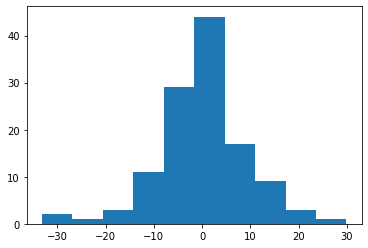

In [270]:
plt.hist(arb)

In [264]:
sum(arb)/len(arb)

1.0078014184397164

In [ ]:
# Try to figure out how to increase correlation among correlated variables 

In [ ]:
[Choice_AlFarouq_Aminu, Choice_Brook_Lopez, Choice_Julius_Randle, Choice_DeAaron_Fox, Choice_Buddy_Hield, Choice_Jrue_Holiday, Choice_Joel_Embiid]

In [13]:

example_results

,Player,Pos,Avg,Fpts,"NBA $25K Four Point Play [20 Entry Max, 2x Min Cash]",NBA $150K Excellent 8's [$50K to 1st],NBA $15.1K Spin Move [$3K to 1st],NBA $40K SLAM Jam [$10K to 1st],NBA $20K Hall of Famer [$10K to 1st],NBA Single Entry $25 Double Up
0,Rudy Gay,SF/PF/F/UTIL,68.95%,20.75,59.67% (-9.28),53.77% (-15.19),73.39% (4.44),67.50% (-1.45),90.00% (21.05),69.40% (0.44)
1,DeMar DeRozan,SG/SF/F/G/UTIL,66.69%,30.50,60.46% (-6.23),51.28% (-15.41),63.05% (-3.64),64.50% (-2.19),80.00% (13.31),80.85% (14.16)
2,Fred VanVleet,PG/SG/G/UTIL,52.90%,49.75,45.46% (-7.44),42.97% (-9.93),54.52% (1.62),58.00% (5.10),60.00% (7.10),56.47% (3.57)
3,Pascal Siakam,PF/C/F/UTIL,49.65%,53.25,43.48% (-6.17),38.39% (-11.26),40.83% (-8.82),43.00% (-6.65),70.00% (20.35),62.19% (12.54)
4,Jakob Poeltl,C/UTIL,42.61%,23.75,32.36% (-10.25),30.64% (-11.97),43.41% (0.80),46.00% (3.39),60.00% (17.39),43.28% (0.67)
...,...,...,...,...,...,...,...,...,...,...
127,Louis King,SF/PF/F/UTIL,0.00%,NaN,0.00% (0.00),0.00% (0.00),0.00% (0.00),0.00% (0.00),0.00% (0.00),0.00% (0.00)
128,Chimezie Metu,PF/C/F/UTIL,0.00%,NaN,0.00% (0.00),0.00% (0.00),0.00% (0.00),0.00% (0.00),0.00% (0.00),0.00% (0.00)
129,Quinndary Weatherspoon,PG/G/UTIL,0.00%,NaN,0.00% (0.00),0.00% (0.00),0.00% (0.00),0.00% (0.00),0.00% (0.00),0.00% (0.00)
130,Keldon Johnson,SG/SF/F/G/UTIL,0.00%,NaN,0.00% (0.00),0.00% (0.00),0.00% (0.00),0.00% (0.00),0.00% (0.00),0.00% (0.00)


In [46]:
example_projections

{'Ersan Ilyasova': {'ceil': 39.89,
  'floor': 3.76,
  'points': 22.0,
  'salary': 3100.0,
  'team': 'MIL'},
 'Marquese Chriss': {'ceil': 39.47,
  'floor': 12.2,
  'points': 24.84,
  'salary': 3700.0,
  'team': 'CLE'},
 'Rajon Rondo': {'ceil': 49.74,
  'floor': 10.55,
  'points': 35.53,
  'salary': 5300.0,
  'team': 'LAL'},
 'Larry Nance': {'ceil': 73.63,
  'floor': 12.91,
  'points': 39.48,
  'salary': 6000.0,
  'team': 'CLE'},
 'Dennis Schroder': {'ceil': 53.6,
  'floor': 8.19,
  'points': 32.76,
  'salary': 5000.0,
  'team': 'OKC'},
 'Dirk Nowitzki': {'ceil': 36.68,
  'floor': 7.36,
  'points': 20.22,
  'salary': 3200.0,
  'team': 'DAL'},
 'Derrick White': {'ceil': 51.99,
  'floor': 9.89,
  'points': 29.34,
  'salary': 4700.0,
  'team': 'SAS'},
 'Justise Winslow': {'ceil': 51.19,
  'floor': 14.98,
  'points': 30.69,
  'salary': 5000.0,
  'team': 'MIA'},
 'J.J. Redick': {'ceil': 53.11,
  'floor': 12.76,
  'points': 31.5,
  'salary': 5200.0,
  'team': 'PHI'},
 'Wayne Ellington': {'ceil

In [78]:
def make_teams(data):
    teams_data = {}
    for date in data:
        if data[date]["PROJECTIONS"] is not False:
            for person in data[date]["PROJECTIONS"]:
                if data[date]["PROJECTIONS"][person]['team'] in teams_data:
                    teams_data[data[date]["PROJECTIONS"][person]['team']].add(person)
                else:
                    teams_data[data[date]["PROJECTIONS"][person]['team']] = set([person])
    return teams_data

In [79]:
make_teams(data)

{'SAS': {'Bryn Forbes',
  'Chimezie Metu',
  'Dante Cunningham',
  'Davis Bertans',
  'DeMar DeRozan',
  'Derrick White',
  'Drew Eubanks',
  'Jakob Poeltl',
  'LaMarcus Aldridge',
  'Lonnie Walker',
  'Marco Belinelli',
  'Patty Mills',
  'Pau Gasol',
  'Quincy Pondexter',
  'Rudy Gay'},
 'ORL': {'Aaron Gordon',
  'Amile Jefferson',
  'DJ Augustin',
  'Evan Fournier',
  'Isaiah Briscoe',
  'Jarell Martin',
  'Jerian Grant',
  'Jonathan Isaac',
  'Jonathon Simmons',
  'Khem Birch',
  'Michael CarterWilliams',
  'Mohamed Bamba',
  'Nikola Vucevic',
  'Terrence Ross',
  'Wesley Iwundu'},
 'HOU': {'Austin Rivers',
  'Brandon Knight',
  'Chris Chiozza',
  'Chris Paul',
  'Clint Capela',
  'Danuel House',
  'Eric Gordon',
  'Gary Clark',
  'Gerald Green',
  'Iman Shumpert',
  'Isaiah Hartenstein',
  'James Ennis',
  'James Harden',
  'James Nunnally',
  'Justin Jackson',
  'Kenneth Faried',
  'Marquese Chriss',
  'Nene Hilario',
  'PJ Tucker',
  'Terrence Jones',
  'Vincent Edwards'},
 'ATL

In [95]:
def get_random_lineups(results, projections, optimal_variance_ratio=.9, optimal_expected_ratio=.9, num_lineups=10):
    players = list(set(example_projections.keys()).intersection(list(results.Player)))
    max_var = get_max_var(results, projections)
    max_ev = get_max_ev(results, projections)
    #print(max_var)
    
    # Instantiate our problem class
    prob = pulp.LpProblem("NBA Maximizing Var", pulp.LpMaximize)
    choices = LpVariable.dicts("Choice", players, cat='Binary')

    
    # 8 people to a team
    prob += lpSum([choices[v] for v in players]) == 8
    
    #add all the necessary position constraints
    add_all_position_requirements(prob, results, projections, choices)
    #adding in the salary constraint
    prob += pulp.lpDot([choices[v] for v in players],[example_projections[name]['salary'] for name in players]) <= 50001
    
    #additional EV and Var constraints
    prob += pulp.lpDot([choices[v] for v in players],
                       [(example_projections[name]['ceil']/2-example_projections[name]['floor']/2)**2 for name in players]) \
        >= max_var*optimal_variance_ratio
    prob += pulp.lpDot([choices[v] for v in players],[example_projections[name]['points'] for name in players]) \
    >= max_ev*optimal_expected_ratio
    
    opt_values = [1000 for name in players]
    for i in range(num_lineups):
        #optimizing function
        prob += pulp.lpDot([choices[v] for v in players],opt_values), "Total Projection"
        prob.solve()
        #for v in prob.variables():
        #    print(v.name, "=", v.varValue)
        print("actual", (pulp.lpDot([choices[v].varValue for v in players],
                        [get_Fpts(results, name) for name in players])))
        print("results", pulp.lpDot([choices[v].varValue for v in players],[example_projections[name]['points'] for name in players]))
        print([choices[v] for v in players if choices[v].varValue == 1])
        for i in range(len(opt_values)):
            if choices[players[i]].varValue ==1:
                opt_values[i] /=2
        #print(opt_values)
        print("Status:", LpStatus[prob.status])#print(prob.status)
        print(value(prob.objective))
        # The problem data is written to an .lp file
        prob.writeLP("letsee.lp")
        #return(value(prob.objective))
        #return prob
    return(pulp.lpDot([choices[v].varValue for v in players],
                        [get_Fpts(results, name) for name in players])).value()

In [97]:
get_random_lineups(example_results, example_projections,optimal_variance_ratio=.8, optimal_expected_ratio=.8, num_lineups=100)

actual 312.75
results 281.78999999999996
[Choice_Dennis_Schroder, Choice_Jerami_Grant, Choice_Donovan_Mitchell, Choice_Derrick_White, Choice_Cheick_Diallo, Choice_Stephen_Curry, Choice_Julius_Randle, Choice_Josh_Richardson]
Status: Optimal
8000.0
actual 211.75
results 261.19
[Choice_Terrence_Ross, Choice_Mike_Conley, Choice_Myles_Turner, Choice_Ersan_Ilyasova, Choice_Devin_Booker, Choice_DeMar_DeRozan, Choice_Gary_Harris, Choice_Jonas_Valanciunas]
Status: Optimal
8000.0
actual 232.75
results 277.58
[Choice_Nikola_Mirotic, Choice_Russell_Westbrook, Choice_Bam_Adebayo, Choice_Jerami_Grant, Choice_DeMarre_Carroll, Choice_Jae_Crowder, Choice_Stephen_Curry, Choice_Kelly_Oubre]
Status: Optimal
7000.0
actual 223.25
results 262.32
[Choice_Jarrett_Allen, Choice_Myles_Turner, Choice_Jerami_Grant, Choice_JJ_Redick, Choice_Mason_Plumlee, Choice_Nikola_Vucevic, Choice_Stephen_Curry, Choice_Jonathan_Isaac]
Status: Optimal
6000.0
actual 279.0
results 270.09999999999997
[Choice_LeBron_James, Choice_Mi

actual 203.5
results 256.46
[Choice_Jarrett_Allen, Choice_Mike_Conley, Choice_Jerami_Grant, Choice_Royce_ONeale, Choice_Stephen_Curry, Choice_DeMar_DeRozan, Choice_Ed_Davis, Choice_Julius_Randle]
Status: Optimal
2532.2265629074536
actual 205.75
results 249.53
[Choice_Jonas_Jerebko, Choice_Mike_Conley, Choice_Jerami_Grant, Choice_Stephen_Curry, Choice_Devin_Booker, Choice_Jonathan_Isaac, Choice_Julius_Randle, Choice_DJ_Wilson]
Status: Optimal
2501.464843953727
actual 226.0
results 253.29999999999998
[Choice_Mike_Conley, Choice_Jerami_Grant, Choice_Will_Barton, Choice_Stephen_Curry, Choice_Devin_Booker, Choice_Abdel_Nader, Choice_Julius_Randle, Choice_Rondae_HollisJefferson]
Status: Optimal
2500.7324219768634
actual 204.5
results 271.39
[Choice_Jalen_Brunson, Choice_Mike_Conley, Choice_Juancho_Hernangomez, Choice_Jerami_Grant, Choice_Stephen_Curry, Choice_Devin_Booker, Choice_Julius_Randle, Choice_Rajon_Rondo]
Status: Optimal
2500.3662109884317
actual 238.5
results 259.46
[Choice_Myles_T

actual 290.0
results 269.88
[Choice_Dwight_Powell, Choice_Myles_Turner, Choice_Jerami_Grant, Choice_Donovan_Mitchell, Choice_Draymond_Green, Choice_Stephen_Curry, Choice_Jonathon_Simmons, Choice_Julius_Randle]
Status: Optimal
1515.625000014552
actual 228.5
results 262.65
[Choice_Mike_Conley, Choice_Jerami_Grant, Choice_TJ_McConnell, Choice_Stephen_Curry, Choice_Devin_Booker, Choice_Julius_Randle, Choice_Andre_Iguodala, Choice_Reggie_Bullock]
Status: Optimal
1500.0010132789612
actual 238.75
results 265.03
[Choice_Mike_Conley, Choice_Jakob_Poeltl, Choice_Jerami_Grant, Choice_Josh_Jackson, Choice_Stephen_Curry, Choice_Devin_Booker, Choice_Darius_Miller, Choice_Julius_Randle]
Status: Optimal
1500.0005066394806
actual 260.5
results 264.11
[Choice_Dion_Waiters, Choice_Evan_Fournier, Choice_Myles_Turner, Choice_Jerami_Grant, Choice_Jordan_Bell, Choice_Stephen_Curry, Choice_Devin_Booker, Choice_Julius_Randle]
Status: Optimal
1500.000238425855
actual 248.75
results 259.62
[Choice_Myles_Turner, 

247.25

In [63]:
 prob = pulp.LpProblem("NBA Maximizing Var", pulp.LpMaximize)

In [64]:
dir(prob)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_variable_ids',
 '_variables',
 'add',
 'addConstraint',
 'addVariable',
 'addVariables',
 'assignConsPi',
 'assignConsSlack',
 'assignVarsDj',
 'assignVarsVals',
 'coefficients',
 'constraints',
 'copy',
 'deepcopy',
 'dummyVar',
 'extend',
 'fixObjective',
 'getSense',
 'get_dummyVar',
 'infeasibilityGap',
 'initialValues',
 'isMIP',
 'lastUnused',
 'modifiedConstraints',
 'modifiedVariables',
 'name',
 'noOverlap',
 'normalisedNames',
 'numConstraints',
 'numVariables',
 'objective',
 'resolve',
 'resolveOK',
 'restoreObjective',
 'roundSolution',
 'sense',
 'sequentialSo

In [101]:
example_contest[example_contest["Points"] > 324]

,Rank,User,Points,Entries,Prize
0,1,mariob888,370.00,67,"$67,500"
1,1,mariob888,370.00,67,"$67,500"
2,3,ManateeJackson,364.00,4,"$20,000"
3,4,ragingphilip,358.25,150,"$10,000"
4,5,apr022,358.00,1,"$4,000"
...,...,...,...,...,...
37,332,p0cket00 Member,324.25,150,$50
38,332,bearsfan6 Member,324.25,150,$50
39,332,Hennessey Member,324.25,150,$50
40,332,GreyPoupon,324.25,150,$50


In [102]:
data[DATE]['CONTESTS'][0]

{'Name': 'NBA $400K Saturday Special [$100K to 1st]',
 'Link': 'Contest',
 'Prize Pool': '$400,000',
 'Buy In': '$15',
 'Top Prize': '$100,000',
 'Max Entries': 150,
 'Entries': 31373,
 'Cash Line': 283.75,
 'Winner': 'mariob888 | mariob888',
 'Winning Score': 370.0,
 'PAYOUTS':     Rank            User  Points Entries    Prize
 0      1       mariob888  370.00      67  $67,500
 1      1       mariob888  370.00      67  $67,500
 2      3  ManateeJackson  364.00       4  $20,000
 3      4    ragingphilip  358.25     150  $10,000
 4      5          apr022  358.00       1   $4,000
 ..   ...             ...     ...     ...      ...
 45  6586       Anonymous  283.50       1      ---
 46  6586       Anonymous  283.50      11      ---
 47  6586       Anonymous  283.50       1      ---
 48  6586       Anonymous  283.50       5      ---
 49  6586       Anonymous  283.50     150      ---
 
 [6650 rows x 5 columns]}